## Example 08 - Multiple vessels

### Imports
Import the required libraries

In [41]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.plot as plot

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

In [42]:
# Graph location
selection = 3

if selection==1:
    # graph of Amsterdam Canals
    location_graph = "Shape-Files/Amsterdam-Canals"
    name_graph = "final_network_v4.shp"

elif selection ==2:
    # graph of Rotterdam-Antwerp transport corridor
    location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
    name_graph = "edges_2.shp"
        
elif selection ==3:
    # graph of all waterways in the Netherlands
    location_graph = "Shape-Files/Vaarwegvakken"
    name_graph = "Vaarwegvakken.shp"

elif selection ==4:
    # NB: not a navigable graph, rather a shapefile containing km marks
    location_graph = "Shape-Files/Kilometermarkeringen"
    name_graph = "kmmarkeringen.shp"

In [43]:
# print graph that is selected
print(location_graph)
print(name_graph)

Shape-Files/Vaarwegvakken
Vaarwegvakken.shp


### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [44]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

Conversion did not create an exact similar graph

Original graph
Name: 
Type: DiGraph
Number of nodes: 3336
Number of edges: 3712
Average in degree:   1.1127
Average out degree:   1.1127

New graph
Name: 
Type: DiGraph
Number of nodes: 3336
Number of edges: 7424
Average in degree:   2.2254
Average out degree:   2.2254


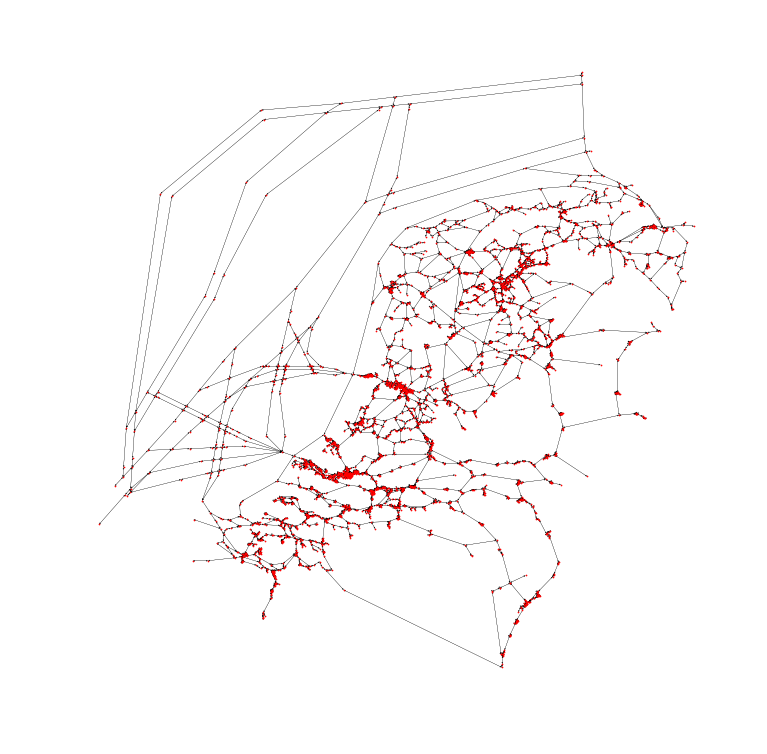

In [45]:
graph.create_graph_new_projection()
graph.plot()

### Make vessels and paths

In [46]:
# number of vessels to generate
nr_of_vessels = 30

In [47]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

vessels = []
for i in range(nr_of_vessels):
    vessel = TransportResource(**data_vessel)
    vessel.name = "Vessel " + str(i + 1)
    vessels.append(vessel)

In [48]:
paths = []
for i in range(nr_of_vessels):
    random_1 = random.choice(list(graph.graph))
    random_2 = random.choice(list(graph.graph))
    
    path = nx.dijkstra_path(graph.graph, random_1, random_2)
    
    paths.append(path)

### Start simulation

In [49]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(env.FG, "Geometry")[vessel.route[-1]]:
            break

In [50]:
# Start simpy environment
env = simpy.Environment()

# Add graph to environment
env.FG = graph.graph

for i, vessel in enumerate(vessels):
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = paths[i]
    vessel.geometry = nx.get_node_attributes(graph.graph, "Geometry")[paths[i][0]]

    # Add the movements of the vessel to the simulation
    env.process(start(env, vessel))

env.epoch = datetime.datetime.now()

env.run()

### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [51]:
vessel_log = pd.DataFrame.from_dict(vessels[0].log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,0.000000,,POINT (4.310207156719842 51.89614061228036)
1,"Sailing from node (4.310207, 51.896141) to nod...",4923.161751,4923.16,POINT (4.245100129950727 51.91447051730091)
2,"Sailing from node (4.245100, 51.914471) to nod...",11950.594039,7027.43,POINT (4.165984116598946 51.95443724477401)
3,"Sailing from node (4.165984, 51.954437) to nod...",15565.623464,3615.03,POINT (4.124486850123233 51.97439931231887)
4,"Sailing from node (4.124487, 51.974399) to nod...",15669.868798,104.245,POINT (4.123105071609672 51.97478601064547)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

In [52]:
for vessel in vessels:
    geom_x = []
    geom_y = []

    for geom in vessel.log["Geometry"]:
        geom_x.append(geom.x)
        geom_y.append(geom.y)

    vessel.log["Geometry - x"] = geom_x
    vessel.log["Geometry - y"] = geom_y

In [53]:
time_stamp_min = []
time_stamp_max = []

for vessel in vessels:
    time_stamp_min.append(min(vessel.log["Timestamp"]))
    time_stamp_max.append(max(vessel.log["Timestamp"]))

time_stamp_min = min(time_stamp_min)
time_stamp_max = max(time_stamp_max)

stepsize = 60
steps = int(np.floor((time_stamp_max - time_stamp_min) / stepsize))

timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)
for vessel in vessels:
    vessel.log["timestamps_x"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - x"])
    vessel.log["timestamps_y"] = np.interp(timestamps_t, vessel.log["Timestamp"], vessel.log["Geometry - y"])

In [54]:
# Create a mp4 animation 
# %%time

# # Make the animation
# fig = plt.figure(figsize = [12, 12])

# nx.draw(graph.graph, nx.get_node_attributes(graph.graph, 'Position'), 
#         with_labels = False, 
#         node_size = 0.5,
#         font_size = 2, 
#         width = 0.2, 
#         arrowsize = 3)


# location_1, = plt.plot([], [], color = "#1f77b4", marker = "o", markersize=15)
# path_1,     = plt.plot([], [], color = "#1f77b4")

# location_2, = plt.plot([], [], color = "#ff7f0e", marker = "o", markersize=15)
# path_2,     = plt.plot([], [], color = "#ff7f0e")

# location_3, = plt.plot([], [], color = "#2ca02c", marker = "o", markersize=15)
# path_3,     = plt.plot([], [], color = "#2ca02c")

# location_4, = plt.plot([], [], color = "#d62728", marker = "o", markersize=15)
# path_4,     = plt.plot([], [], color = "#d62728")

# location_5, = plt.plot([], [], color = "#9467bd", marker = "o", markersize=15)
# path_5,     = plt.plot([], [], color = "#9467bd")

# def init():
#     location_1.set_data([], [])
#     path_1.set_data([], [])
    
#     location_2.set_data([], [])
#     path_2.set_data([], [])
    
#     location_3.set_data([], [])
#     path_3.set_data([], [])
    
#     location_4.set_data([], [])
#     path_4.set_data([], [])
    
#     location_5.set_data([], [])
#     path_5.set_data([], [])

# def animate(i):
#     for j, vessel in enumerate(vessels):
#         this_x = [vessel.log["timestamps_x"][i]]
#         this_y = [vessel.log["timestamps_y"][i]]

#         past_x = [x for x in vessel.log["timestamps_x"][:i]]
#         past_y = [y for y in vessel.log["timestamps_y"][:i]]

#         if j == 0:
#             location_1.set_data(this_x, this_y)
#             path_1.set_data(past_x, past_y)
#         elif j == 1:
#             location_2.set_data(this_x, this_y)
#             path_2.set_data(past_x, past_y)
#         elif j == 2:
#             location_3.set_data(this_x, this_y)
#             path_3.set_data(past_x, past_y)
#         elif j == 3:
#             location_4.set_data(this_x, this_y)
#             path_4.set_data(past_x, past_y)
#         elif j == 4:
#             location_5.set_data(this_x, this_y)
#             path_5.set_data(past_x, past_y)

#     return location_1, location_2, location_3, location_4, location_5, path_1, path_2, path_3, path_4, path_5
    
        
# ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
# ani.save('route - improved - example 08.mp4', fps=5)

In [55]:
# visualise vessel movements based on the information included in the vessel.log
plot.vessel_kml(env, vessels)
plot.graph_kml(env)

In [56]:
# open the file
if platform.system():
    !start ./graph.kml
    !start ./vessel_movements.kml
    
else:
    !start explorer ./graph.kml
    !start explorer ./vessel_movements.kml


## create time distance diagram
to do:
* time distance diagrams should be generated for a base path
 * time_distance_diagram(base_path, vessels)
* the x axis can then be distance on the base path in m from the origin of the base path
 * can be done with location_to_distance
* for every vessel its location should be converted to this axis (so distance from the origin)
 * can be done with location to distance (offset with the starting point of the vessel)
* the plot should only show movement of the vessel on that base path
 * a filter should be built that extracts from the vessel log the movement on the base path
 * this can be done with networkx intersection if you have both the base path and the vessel path

In [57]:
vessel.__dict__

{'compute_v': <function __main__.compute_v_provider.<locals>.<lambda>>,
 'container': <simpy.resources.container.Container at 0x18c11c8cb70>,
 'env': <simpy.core.Environment at 0x18c0ce91a58>,
 'geometry': <shapely.geometry.point.Point at 0x18c0e33a828>,
 'id': '1949f230-16ae-11e9-bf6b-60f677ba2ce0',
 'log': {'Geometry': [<shapely.geometry.point.Point at 0x18c0e3cda90>,
  'Geometry - x': [6.926753739740478,
   6.9708994292425,
   6.8816749597646165,
   6.519903146558056,
   6.519860255847565,
   6.1499300763997535,
   6.157932852823202,
   6.162529346459269,
   6.170144148186781,
   6.179504333416801,
   6.1857155886886055,
   6.431255128918443,
   6.531637604728141,
   6.601993580866803,
   6.577350202271997,
   6.559971028377429,
   6.576652129409112,
   6.5811132906451055,
   6.596919192685957,
   6.597693131025952,
   6.598476875608686,
   6.599489732670573,
   6.620757235902945,
   6.645668845616382,
   6.655485060425561,
   6.689543265711125,
   6.6950503980313005,
   6.698863699

In [58]:
def convert_time_to_duration(series):
    param = [0]

    for log_index, value in enumerate(series[0:-1-1:1]):
        # calcuate intervals
        start = series[log_index]
        stop = series[log_index + 1]
        duration = stop - start

        param.append(param[-1] + duration)

    return param

def convert_location_to_distance(series):
    param = [0]

    for log_index, value in enumerate(series[0:-1-1:1]):
        # calcuate intervals
        orig = vessel.log["Geometry"][log_index]
        dest = vessel.log["Geometry"][log_index + 1]

        distance = vessel.wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                    shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]

        param.append(param[-1] + distance)

    return param        

times = convert_time_to_duration(vessel.log["Timestamp"])
distances = convert_location_to_distance(vessel.log["Geometry"])

Text(0,0.5,'time [s]')

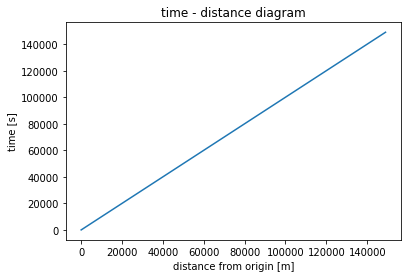

In [59]:
plt.plot(distances, times)
plt.title('time - distance diagram')
plt.xlabel('distance from origin [m]')
plt.ylabel('time [s]')

# diagram should be perfectly one on one, since we made speed equal to distance